# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/FER465/

/content/drive/MyDrive/FER465


In [3]:
%cd /content/drive/MyDrive/FER465/
!git config --global user.email "riad.safowan@northsouth.edu"
!git config --global user.name "Riad Safowan"

/content/drive/MyDrive/FER465


In [4]:
import os
print(os.getcwd())

/content/drive/MyDrive/FER465


In [ ]:
!git add .
!git commit -m ""
!git push -u origin main

[main 82f9584] 30% Data augmentation for FER-2013 dataset
 3 files changed, 11 insertions(+), 1 deletion(-)
 create mode 100644 FER465.ipynb
 rewrite README.md (100%)
 create mode 100644 augmented-data/fer-2013-aug.zip
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 13.15 MiB | 4.25 MiB/s, done.
Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/riad-safowan/CSE465_Spring2025_Group-01.git
   19a639a..82f9584  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


# Dataset

Get the dataset of FER-2013

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

!mkdir -p /content/FER-2013
!mv {path}/test/ /content/FER-2013/test
!mv {path}/train/ /content/FER-2013/train


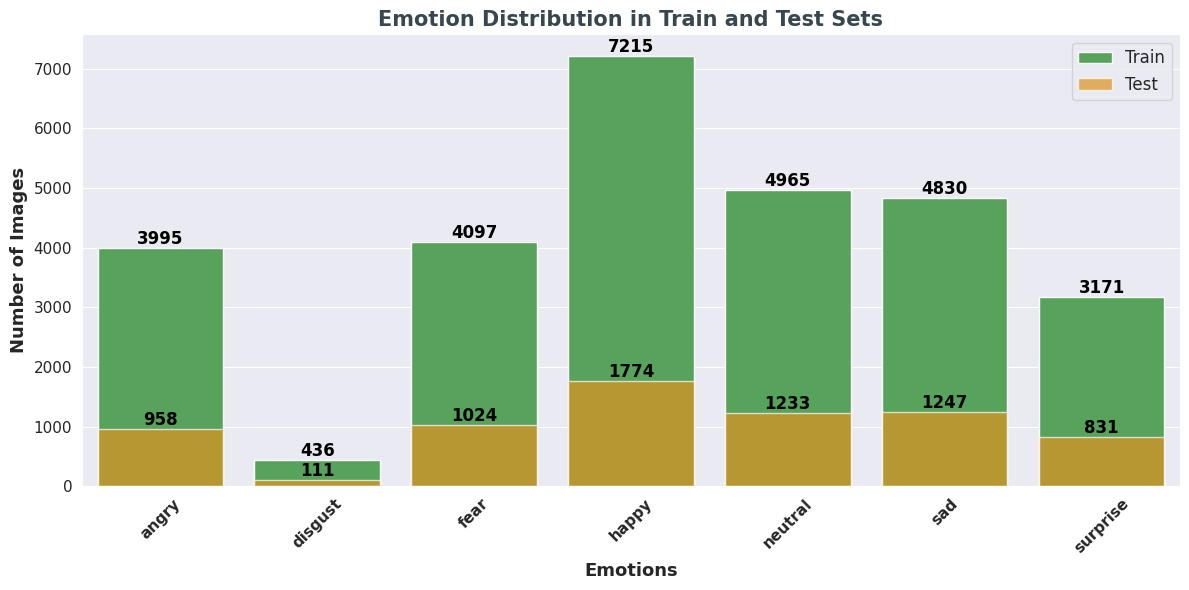

Total Train Images: 28709
Total Test Images: 7178
Train-Test Ratio: 80:20
Total Images in Dataset: 35887


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_emotion_dataset(data_dir):
    # Set Seaborn style
    sns.set_style("darkgrid")

    # Define dataset paths
    TRAIN_DIR = os.path.join(data_dir, "train")
    TEST_DIR = os.path.join(data_dir, "test")

    def count_images(directory):
        """Returns a dictionary with the count of images per emotion category."""
        return {emotion: len(os.listdir(os.path.join(directory, emotion)))
                for emotion in sorted(os.listdir(directory))}

    # Count images in train and test sets
    train_counts = count_images(TRAIN_DIR)
    test_counts = count_images(TEST_DIR)

    # Compute dataset statistics
    total_train, total_test = sum(train_counts.values()), sum(test_counts.values())
    total_images = total_train + total_test

    # Plot distribution
    plt.figure(figsize=(12, 6))

    # Define colors
    train_color = "#4CAF50"  # Green
    test_color = "#FF9800"   # Orange

    ax = sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()),
                     color=train_color, label="Train")
    sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()),
                color=test_color, alpha=0.7, label="Test")

    # Annotate bars with counts
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    plt.xlabel("Emotions", fontsize=13, fontweight="bold")
    plt.ylabel("Number of Images", fontsize=13, fontweight="bold")
    plt.title("Emotion Distribution in Train and Test Sets", fontsize=15, fontweight="bold", color="#37474F")
    plt.legend(fontsize=12)
    plt.xticks(rotation=45, fontsize=11, fontweight="bold")
    plt.yticks(fontsize=11)

    plt.tight_layout()
    plt.show()

    # Display dataset statistics
    print(f"Total Train Images: {total_train}")
    print(f"Total Test Images: {total_test}")
    train_percent = (total_train * 100) / total_images
    test_percent = (total_test * 100) / total_images
    print(f"Train-Test Ratio: {round(train_percent)}:{round(test_percent)}")
    print(f"Total Images in Dataset: {total_images}")

visualize_emotion_dataset("/content/FER-2013")

# Data Augmentation

In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import shutil
import zipfile

# Define dataset paths
data_dir = "/content/FER-2013"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
output_dir = "/content/FER-2013/all"
output_zip = "/content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip"

# Clear the output directory if it exists
if os.path.exists(output_dir):
    print(f"Cleaning existing output directory: {output_dir}")
    shutil.rmtree(output_dir)

# Create fresh output directory
os.makedirs(output_dir, exist_ok=True)

def augment_image(image):
    """Apply a single random augmentation to the image"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Randomly choose one augmentation technique
    augmentation_type = random.choice(['rotate', 'shift', 'flip', 'erase'])

    if augmentation_type == 'rotate':
        # Random rotation (-15 to +15 degrees)
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    elif augmentation_type == 'shift':
        # Random shifting (-10% to +10%)
        max_shift = int(0.1 * min(h, w))
        shift_x, shift_y = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    elif augmentation_type == 'flip':
        # Horizontal flip
        return cv2.flip(image, 1)

    elif augmentation_type == 'erase':
        # Random erasing
        erase_size = (random.randint(5, 10), random.randint(5, 10))
        erase_h, erase_w = erase_size
        # Ensure erasing region fits within the image
        x, y = random.randint(0, w - erase_w), random.randint(0, h - erase_h)
        augmented = image.copy()
        augmented[y:y + erase_h, x:x + erase_w] = 0  # Set erased region to black
        return augmented

def augment_dataset(src_dir, dst_dir, augmentation_percentage=30):
    """Copies all original images and adds augmented images to reach the target percentage increase"""

    # Copy the original dataset structure first
    for root, dirs, files in os.walk(src_dir):
        relative_path = os.path.relpath(root, src_dir)
        target_dir = os.path.join(dst_dir, relative_path)

        # Create the target directory if it doesn't exist
        os.makedirs(target_dir, exist_ok=True)

        # Copy all original files
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_file = os.path.join(root, file)
                dst_file = os.path.join(target_dir, file)
                shutil.copy2(src_file, dst_file)

    # Now add augmented images
    for emotion in sorted(os.listdir(src_dir)):
        emotion_dir = os.path.join(src_dir, emotion)
        dst_emotion_dir = os.path.join(dst_dir, emotion)

        # Get list of image files
        image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Calculate how many images to augment
        num_to_augment = int(len(image_files) * (augmentation_percentage / 100))

        # Randomly select images to augment
        images_to_augment = random.sample(image_files, num_to_augment)

        # Augment selected images
        for img_file in tqdm(images_to_augment, desc=f"Augmenting {emotion}"):
            img_path = os.path.join(emotion_dir, img_file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                augmented = augment_image(image)
                aug_filename = f"aug_{img_file}"
                cv2.imwrite(os.path.join(dst_emotion_dir, aug_filename), augmented)

# Process train and test datasets
print("Augmenting training data...")
augment_dataset(train_dir, os.path.join(output_dir, "train"), 30)

print("Augmenting test data...")
augment_dataset(test_dir, os.path.join(output_dir, "test"), 30)

# Create a zip file of the augmented data
print("Creating zip file...")
with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(output_dir)))

print(f"Augmentation complete. Zip file saved to {output_zip}")


Cleaning existing output directory: /content/FER-2013/all
Augmenting training data...


Augmenting surprise: 100%|██████████| 951/951 [00:00<00:00, 5095.32it/s]


Augmenting test data...


Augmenting surprise: 100%|██████████| 249/249 [00:00<00:00, 4675.61it/s]


Creating zip file...
Augmentation complete. Zip file saved to /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip


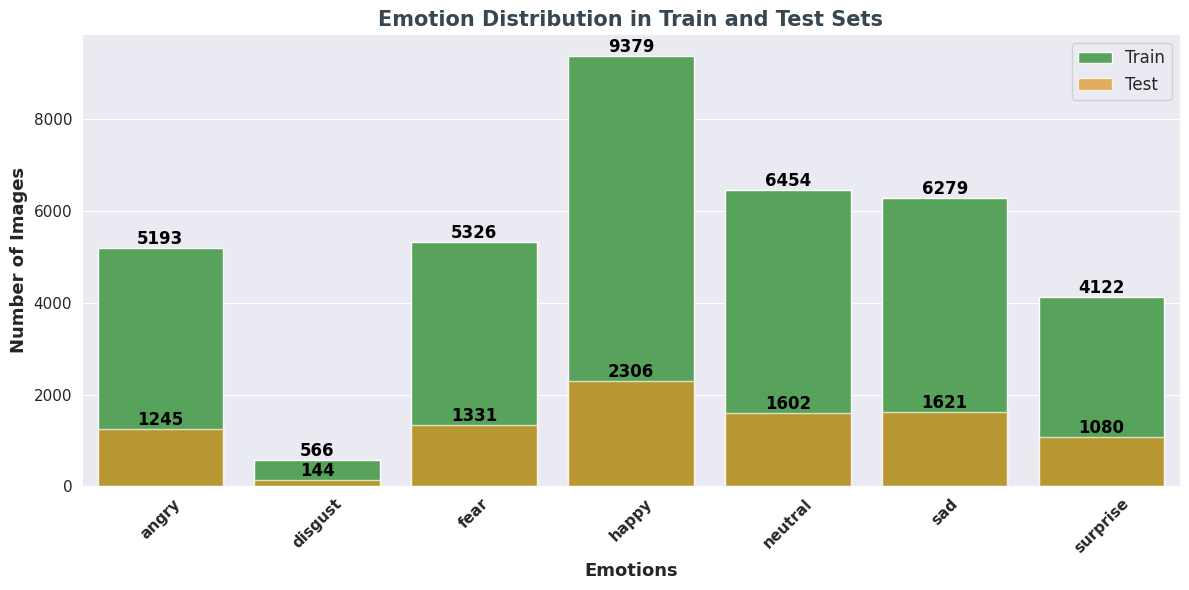

Total Train Images: 37319
Total Test Images: 9329
Train-Test Ratio: 80:20
Total Images in Dataset: 46648


In [ ]:
visualize_emotion_dataset("/content/FER-2013/all")

In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import shutil
import zipfile

# Define dataset paths
data_dir = "/content/FER-2013"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
output_dir = "/content/FER-2013/augmented"
output_zip = "/content/drive/MyDrive/FER465/augmented-data/fer-2013-aug.zip"

# Clear the output directory if it exists
if os.path.exists(output_dir):
    print(f"Cleaning existing output directory: {output_dir}")
    shutil.rmtree(output_dir)

# Create fresh output directory
os.makedirs(output_dir, exist_ok=True)

def augment_image(image):
    """Apply a single random augmentation to the image"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Randomly choose one augmentation technique
    augmentation_type = random.choice(['rotate', 'shift', 'flip', 'erase'])

    if augmentation_type == 'rotate':
        # Random rotation (-15 to +15 degrees)
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    elif augmentation_type == 'shift':
        # Random shifting (-10% to +10%)
        max_shift = int(0.1 * min(h, w))
        shift_x, shift_y = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    elif augmentation_type == 'flip':
        # Horizontal flip
        return cv2.flip(image, 1)

    elif augmentation_type == 'erase':
        # Random erasing
        erase_size = (random.randint(5, 10), random.randint(5, 10))
        erase_h, erase_w = erase_size
        # Ensure erasing region fits within the image
        x, y = random.randint(0, w - erase_w), random.randint(0, h - erase_h)
        augmented = image.copy()
        augmented[y:y + erase_h, x:x + erase_w] = 0  # Set erased region to black
        return augmented

def create_augmented_dataset(src_dir, dst_dir, augmentation_percentage=30):
    """Creates only augmented images (no originals) in the output directory"""

    # Create the output directory structure
    for emotion in sorted(os.listdir(src_dir)):
        emotion_dir = os.path.join(src_dir, emotion)
        dst_emotion_dir = os.path.join(dst_dir, emotion)

        # Create the target directory if it doesn't exist
        os.makedirs(dst_emotion_dir, exist_ok=True)

        # Get list of image files
        image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Calculate how many images to augment (30% of original dataset)
        num_to_augment = int(len(image_files) * (augmentation_percentage / 100))

        # Randomly select images to augment
        images_to_augment = random.sample(image_files, num_to_augment)

        # Augment selected images
        for img_file in tqdm(images_to_augment, desc=f"Augmenting {emotion}"):
            img_path = os.path.join(emotion_dir, img_file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                augmented = augment_image(image)
                aug_filename = f"aug_{img_file}"
                cv2.imwrite(os.path.join(dst_emotion_dir, aug_filename), augmented)

# Process train and test datasets
print("Creating augmented training data...")
create_augmented_dataset(train_dir, os.path.join(output_dir, "train"), 30)

print("Creating augmented test data...")
create_augmented_dataset(test_dir, os.path.join(output_dir, "test"), 30)

# Create a zip file of the augmented data
print("Creating zip file...")
with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(output_dir)))

print(f"Augmentation complete. Zip file saved to {output_zip}")

Cleaning existing output directory: /content/FER-2013/augmented
Creating augmented training data...


Augmenting surprise: 100%|██████████| 951/951 [00:00<00:00, 2539.66it/s]


Creating augmented test data...


Augmenting surprise: 100%|██████████| 249/249 [00:00<00:00, 4396.08it/s]


Creating zip file...
Augmentation complete. Zip file saved to /content/drive/MyDrive/FER465/augmented-data/fer-2013-aug.zip


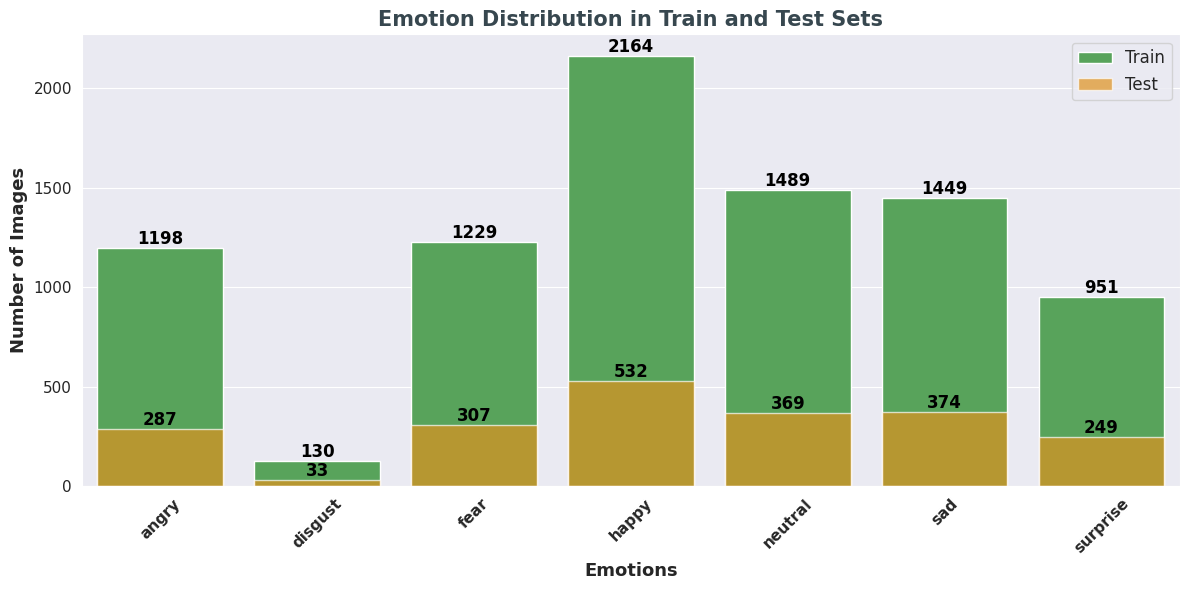

Total Train Images: 8610
Total Test Images: 2151
Train-Test Ratio: 80:20
Total Images in Dataset: 10761


In [ ]:
visualize_emotion_dataset("/content/FER-2013/augmented")